In [2]:
#  from detection_v2 import VideoObjectDetection
import os
import pickle
import cv2
import matplotlib.pyplot as plt
import numpy as np

## Use image ai to detect only human from the video
changed the code to output to 'data.pickle' all the bounding box and possibilities and the class label.

In [ ]:
execution_path = os.getcwd()
detector = VideoObjectDetection()
detector.setModelTypeAsRetinaNet()
detector.setModelPath( os.path.join(execution_path , "resnet50_coco_best_v2.0.1.h5"))
detector.loadModel("normal")

custom_objects = detector.CustomObjects(person=True)

video_path = detector.detectCustomObjectsFromVideo(custom_objects=custom_objects, 
                                        input_file_path=os.path.join(execution_path, "test6.mp4"),
                                        output_file_path=os.path.join(execution_path, "traffic_custom_detected"),
                                        frames_per_second=20, log_progress=True)

## Define a class for our task of tracking human

In [170]:
class TrackHuman:
    __param = 0.55
    __min_count = 10
    
    def __init__(self, video_file, bbx_file):
        with open(bbx_file, 'rb') as f:
            self.__data = pickle.load(f)
        self.__input_video = cv2.VideoCapture(video_file)
        self.__frame_width = int(self.__input_video.get(3))
        self.__frame_height = int(self.__input_video.get(4))
        ## for feature points
        self.__detection = cv2.xfeatures2d.SURF_create()
        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks=50)   # or pass empty dictionary
        self.__flann = cv2.FlannBasedMatcher(index_params,search_params)

    def set_match_param(self, num):
        self.__param = num
        
    def release_video(self):
        self.__input_video.release()

    def refine_bbx(self , bbx):
        bbx[0] = np.max([0, bbx[0]])
        bbx[1] = np.max([0, bbx[1]])
        #bbx[2] = np.min([self.__frame_height-1, bbx[2]])
        #bbx[3] = np.min([self.__frame_width-1, bbx[3]])
        return bbx
        
    def set_min_count(self, num):
        self.__min_count= num
        
    def get_for_image_plt(self, idx):
        self.__input_video.set(1,idx)
        ret, frame = self.__input_video.read()
        objs = self.__data[idx]["objects"]
        for i in range(len(objs)):
            plt.subplot(1,len(objs), i+1)
            bbx = self.refine_bbx(objs[i]["position"])
            plt.imshow(frame[bbx[1]:bbx[3], bbx[0]:bbx[2],:])
        
    def make_sign(self, img):
        kp, des = self.__detection.detectAndCompute(img,None)
        return des
    
    def plot_match_two_image(self, idx1, obj1,idx2,obj2):
        self.__input_video.set(1,idx1)
        ret, frame = self.__input_video.read()
        bbx = self.__data[idx1]["objects"][obj1]["position"]
        img1 = frame[bbx[1]:bbx[3], bbx[0]:bbx[2],:]
        kp1, des1 = self.__detection.detectAndCompute(img1,None)
        
        self.__input_video.set(1,idx2)
        ret, frame = self.__input_video.read()
        bbx = self.__data[idx2]["objects"][obj2]["position"]
        img2 = frame[bbx[1]:bbx[3], bbx[0]:bbx[2],:]
        kp2, des2 = self.__detection.detectAndCompute(img2,None)
        
        plt.subplot(131);plt.imshow(cv2.drawKeypoints(img1,kp1,None,(255,0,0),4))
        plt.subplot(132);plt.imshow(cv2.drawKeypoints(img2,kp2,None,(255,0,0),4))
        
        # Match descriptors.
        matches = self.__flann.knnMatch(des1,des2,k=2)
        # Need to draw only good matches, so create a mask
        matchesMask = [[0,0] for i in range(len(matches))]
        # ratio test as per Lowe's paper
        for i,(m,n) in enumerate(matches):
            if m.distance < 0.7*n.distance:
                matchesMask[i]=[1,0]
        draw_params = dict(matchColor = (0,255,0),
                           singlePointColor = (255,0,0),
                           matchesMask = matchesMask,
                           flags = 0)
        img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
        plt.subplot(133);plt.imshow(img3)
    
    def get_sign(self, idx_frame, idx_obj):
        self.__input_video.set(1,idx_frame)
        ret, frame = self.__input_video.read()
        objs = self.__data[idx_frame]["objects"]
        bbx = self.refine_bbx(objs[idx_obj]["position"])
        img = frame[bbx[1]:bbx[3], bbx[0]:bbx[2],:]
        return self.make_sign(img)
    
    def match_sign(self, sign , signs):
        counts = []
        for i in range(len(signs)):
            sign_match = signs[i]
            try:
                matches = self.__flann.knnMatch(sign,sign_match,k=2)
            except:
                counts.append(0)
                continue
            count = 0
            for k,(m,n) in enumerate(matches):
                if m.distance < self.__param*n.distance:
                    count += 1
            counts.append(count)
        if len(counts) == 0:
            return None
        if np.max(counts) < self.__min_count:
            return None
        else:
            return np.argmax(counts)
    
    def match_update_sign(self, sign , signs, sign_com):
        counts = []
        common_des = []
        for i in range(len(signs)):
            sign_match = signs[i]
            try:
                matches = self.__flann.knnMatch(sign,sign_match,k=2)
            except:
                counts.append(0)
                continue
            try:
                matches_com = self.__flann.knnMatch(sign_com,sign_match,k=2)
            except:
                matches_com = []
            count = 0
            des = []
            for k,(m,n) in enumerate(matches):
                if m.distance < self.__param*n.distance:
                    count += 1
                    des.append(sign[m.queryIdx])
            count_com = 0
            for k,(m,n) in enumerate(matches_com):
                if m.distance < (self.__param)*n.distance:
                    count_com += 1
            if len(sign_com)>0:
                count += count_com*300/sign_com.shape[0]
            counts.append(count)
            common_des.append(des)
        if len(counts) == 0:
            return None, sign_com
        if np.max(counts) < self.__min_count:
            return None, sign_com
        else:
            idx = np.argmax(counts)
            com_new = np.array(common_des[idx])
            return idx, np.concatenate((sign_com,com_new),axis = 0)
        
            
    def get_for_image(self, idx, sign_old, sign_com):
        self.__input_video.set(1,idx)
        ret, frame = self.__input_video.read()
        objs = self.__data[idx]["objects"]
        imgs = []
        signs = []
        for i in range(len(objs)):
            if float(objs[i]["percentage_probability"]) > 75:
                bbx = self.refine_bbx(objs[i]["position"])
                surface = (bbx[3]-bbx[1])*(bbx[2]-bbx[1])
                if surface < 30000:
                    #print(surface)
                    continue
                img = frame[bbx[1]:bbx[3], bbx[0]:bbx[2],:]
                sign = self.make_sign(img)
                imgs.append(img) 
                signs.append(sign)
        idx = self.match_sign(sign_old, signs)
        idx, sign_com = self.match_update_sign(sign_old, signs, sign_com)
        if idx is None:
            return None, sign_old, sign_com
        return imgs[idx], signs[idx], sign_com

## 1.1 get the objects from the image ai result

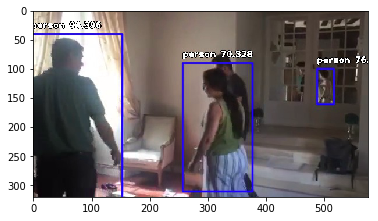

In [3]:
input_video = cv2.VideoCapture("traffic_custom_detected.avi")
input_video.set(1,177)
ret, frame = input_video.read()
plt.imshow(frame)

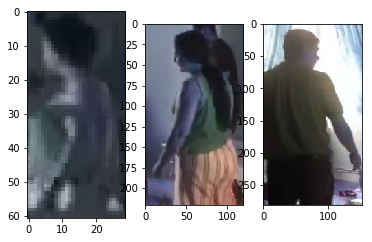

In [82]:
th = TrackHuman('test6.mp4', 'data.pickle')
th.get_for_image_plt(177)

#### PROBLEM with it
1. the overlapping of two people
2. the "human" in the mirror

## 1.2 get the images of one object to make a video
#### using SURF points as the signature
the signature are built by two parts:
1. the matching points of the last image of this object (as they are in a video, the object in near by frame should be very similarity to each other).
2. the common matched feature points of all the frequence (to not lost the object when the detection of imageai failed).

#### example of sequence of images

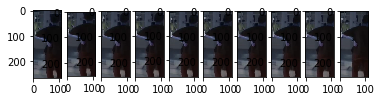

In [198]:
th = TrackHuman('test6.mp4', 'data.pickle')
th.set_min_count(10)
th.set_match_param(0.7)
sign_old = th.get_sign(60,1)
sign_com = np.zeros((0,64))
for i in range(60,70):
    img , sign_old, sign_com = th.get_for_image(i, sign_old, sign_com)
    if not img is None:
        plt.subplot(1,10,i-60+1);plt.imshow(img)

In [150]:
th = TrackHuman('test6.mp4', 'data.pickle')
th.set_min_count(10)
th.set_match_param(0.7)
sign_old = th.get_sign(0,0)
sign_com = np.zeros((0,64))
for i in range(340):
    img , sign_old, sign_com = th.get_for_image(i, sign_old, sign_com)
    if not img is None:
        cv2.imshow('frames2', img)
    k = cv2.waitKey(1) & 0xff
th.release_video()
cv2.destroyAllWindows()

In [151]:
th = TrackHuman('test6.mp4', 'data.pickle')
th.set_min_count(10)
th.set_match_param(0.7)
sign_old = th.get_sign(0,1)
sign_com = np.zeros((0,64))
for i in range(340):
    if i < 60 :
        th.set_match_param(0.8)
        img , sign_old, sign_com = th.get_for_image(i, sign_old, sign_com)
    else:
        th.set_match_param(0.7)
        img , _, _ = th.get_for_image(i, sign_com, np.zeros((0,64)))
    if not img is None:
        cv2.imshow('frames2', img)
    k = cv2.waitKey(1) & 0xff
th.release_video()
cv2.destroyAllWindows()

1. The system tracking well when objects moving seperately, but when objects overlapped, the system may fall.
2. I used a updated learnable signature, but result remay un reliable for overlapping objects.

## 1.3 plot some signature of images and matching of them
## Conclusion
1. the same people of different scene, the surf points cannot match well.
2. may be we should take other features as signature. sift surf points are detecting the feature of structure, but I think the feature we need is the color.
3. the human face recogination can by better.

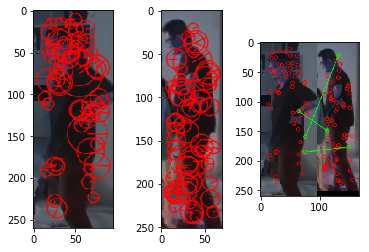

In [185]:
th = TrackHuman('test6.mp4', 'data.pickle')
th.plot_match_two_image(10,1,200,1)

## 1.4 illumination

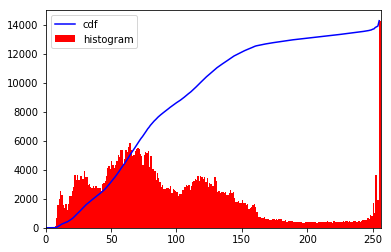

In [19]:
input_video = cv2.VideoCapture("test6.mp4")
input_video.set(1,177)
ret, frame = input_video.read()
img = frame
hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

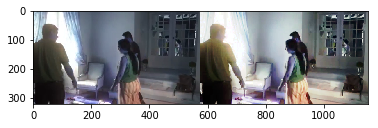

In [20]:
res = np.zeros((320,1152,3))
for i in range(3):
    img = frame[...,i]
    equ = cv2.equalizeHist(img)
    res[...,i] = np.hstack((img,equ)) #stacking images side-by-side
plt.imshow(res.astype(int))